In [27]:
from yahoo_finance_api2 import share
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.spatial.distance import euclidean
import seaborn as sns
import numpy as np
import tsfresh as fresh
import tslearn as tsl
from fastdtw import fastdtw as dtw
import pandas as pd
from itertools import product, combinations
from tsfresh.utilities.dataframe_functions import impute
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN

In [28]:
from IPython.display import set_matplotlib_formats

set_matplotlib_formats('retina')
sns.set(style="darkgrid")
%matplotlib inline

# Helpers

In [29]:
def format_unix_time(timestamp):
    """
    Retorna yyyy-mm-dd a partir de um unix timestamp
    """
    return datetime.date(datetime.fromtimestamp(timestamp))

def date_missing(series, freq):
    """
    Retorna uma serie temporal booleana que indica a presenca de valores na serie original
    para cada data
    """
    all_dates = pd.Series(data=pd.date_range(start=series["timestamp"].min(),
                                             end=series["timestamp"].max(),
                                             freq=freq))
    date_is_missing = all_dates.isin(series["timestamp"].values)


    return pd.DataFrame({
        "timestamp": all_dates,
        "date_missing": ~date_is_missing
    })

def get_ticker_history(ticker):
    """
    Returns ticker history for the past 5 years
    """
    return share.Share(ticker).get_historical(share.PERIOD_TYPE_YEAR,
                                              5,
                                              share.FREQUENCY_TYPE_DAY,
                                              1)

def get_tickers_history(tickers):
    """
    Returns ticker histories for many tickers
    """
    df = pd.DataFrame(get_ticker_history(tickers[0])).assign(ticker=tickers[0])
    for i in range(1, len(tickers)):
        ticker = tickers[i]
        ticker_history = get_ticker_history(ticker)
        nth_df = pd.DataFrame(ticker_history).assign(ticker=ticker)
        df = pd.concat([df, nth_df], axis=0, sort=False)
    return df

# Historico de componentes do nasdaq-100

In [30]:
nasdaq_100 = ["ATVI","ADBE","AMD","ALXN","ALGN","GOOGL","GOOG","AMZN","AAL","AMGN","ADI","AAPL","AMAT","ASML","ADSK","ADP","BIDU","BIIB","BMRN","BKNG","AVGO","CSX","CDNS","CELG","CERN","CHTR","CHKP","CTAS","CSCO","CTXS","CTSH","CMCSA","COST","CTRP","DLTR","EBAY","EA","EXPE","FB","FAST","FISV","FOXA","FOX","GILD","HAS","HSIC","IDXX","ILMN","INCY","INTC","INTU","ISRG","JBHT","JD","KLAC","KHC","LRCX","LBTYA","LBTYK","LULU","MAR","MXIM","MELI","MCHP","MU","MSFT","MDLZ","MNST","MYL","NTAP","NTES","NFLX","NVDA","NXPI","ORLY","PCAR","PAYX","PYPL","PEP","QCOM","REGN","ROST","SIRI","SWKS","SBUX","SYMC","SNPS","TMUS","TTWO","TSLA","TXN","ULTA","UAL","VRSN","VRSK","VRTX","WBA","WDC","WLTW","WDAY","WYNN","XEL","XLNX"]

# Historico de componentes da IBOV
[Fonte](https://br.advfn.com/indice/ibovespa)

In [31]:
ibov = ['ABEV3.SA', 'AZUL4.SA', 'B3SA3.SA', 'BBAS3.SA', 'BBDC3.SA', 'BBDC4.SA', 'BBSE3.SA', 'BPAC11.SA', 'BRAP4.SA', 'BRDT3.SA', 'BRFS3.SA', 'BRKM5.SA', 'BRML3.SA', 'BTOW3.SA', 'CCRO3.SA', 'CIEL3.SA', 'CMIG4.SA', 'CSAN3.SA', 'CSNA3.SA', 'CVCB3.SA', 'CYRE3.SA', 'ECOR3.SA', 'EGIE3.SA', 'ELET3.SA', 'ELET6.SA', 'EMBR3.SA', 'ENBR3.SA', 'EQTL3.SA', 'FLRY3.SA', 'GGBR4.SA', 'GNDI3.SA', 'GOAU4.SA', 'GOLL4.SA', 'HYPE3.SA', 'IGTA3.SA', 'IRBR3.SA', 'ITSA4.SA', 'ITUB4.SA', 'JBSS3.SA', 'KLBN11.SA', 'KROT3.SA', 'LAME4.SA', 'LREN3.SA', 'MGLU3.SA', 'MRFG3.SA', 'MRVE3.SA', 'MULT3.SA', 'NATU3.SA', 'PCAR4.SA', 'PETR3.SA', 'PETR4.SA', 'QUAL3.SA', 'RADL3.SA', 'RAIL3.SA', 'RENT3.SA', 'SANB11.SA', 'SBSP3.SA', 'SMLS3.SA', 'SUZB3.SA', 'TAEE11.SA', 'TIMP3.SA', 'UGPA3.SA', 'USIM5.SA', 'VALE3.SA', 'VIVT4.SA', 'VVAR3.SA', 'WEGE3.SA', 'YDUQ3.SA']

In [32]:
df = get_tickers_history(ibov)

In [33]:
df["timestamp"] = pd.to_datetime(df["timestamp"].apply(lambda row: format_unix_time(row/1000)))

In [34]:
df.head(5)

,timestamp,open,high,low,close,volume,ticker
0,2014-09-24,16.410000,16.540001,16.129999,16.500000,9968600.0,ABEV3.SA
1,2014-09-25,16.350000,16.490000,16.170000,16.360001,867200.0,ABEV3.SA
2,2014-09-26,16.400000,16.559999,16.240000,16.410000,7688500.0,ABEV3.SA
3,2014-09-29,16.110001,16.209999,15.810000,16.160000,17476600.0,ABEV3.SA
4,2014-09-30,16.049999,16.230000,15.930000,16.040001,11496800.0,ABEV3.SA


# Dados ausentes

## Atributos incompletos

In [35]:
bad_tickers = df[df.isna().any(axis=1)]["ticker"].unique()
print(bad_tickers)

['AZUL4.SA' 'SANB11.SA' 'SUZB3.SA']


In [36]:
df.isna().mean()

timestamp    0.000000
open         0.007795
high         0.007795
low          0.007795
close        0.007795
volume       0.007795
ticker       0.000000
dtype: float64

Serão desconsideradas as series que possuem dados faltando

In [37]:
df = df[~df["ticker"].isin(bad_tickers)]

## Amostragens ausentes

Primeiro devemos verificar se o numero de amostragens de cada ticker é o mesmo, removendo tickers que falhem esse teste.

In [38]:
freq = df["ticker"].value_counts()
bad_tickers = freq[freq.lt(freq.max())].index.values

df = df[~df["ticker"].isin(bad_tickers)]

As linhas que estão ausentes correspondem a finais de semana e feriados, como no Brasil há apenas uma bolsa - BOVESPA -, espera-se que as series temporais estejam com amostragens faltando exatamente no mesmos pontos.

In [39]:
unique_tickers = df["ticker"].unique()
missing_series = date_missing(df[df["ticker"] == unique_tickers[0]], "D")

In [40]:
bad_tickers = []
for ticker in unique_tickers:
    bad_ticker = (date_missing(df[df["ticker"] == ticker], "D") == missing_series)
    if not bad_ticker.all().all():
        bad_tickers.append(ticker)
bad_tickers

[]

Todos os valores ausentes estão temporalmente alinhados

In [41]:
print("Ainda sobraram {} series".format(len(df.ticker.unique())))

Ainda sobraram 57 series


# Clustering

In [42]:
from tslearn.metrics import dtw

In [43]:
unique_tickers = df.ticker.unique()
df_distances = pd.DataFrame(columns=unique_tickers, index=unique_tickers)
ticker_pairs = list(combinations(df["ticker"].unique(), 2))

In [44]:
df_distances = pd.DataFrame(columns=unique_tickers, index=unique_tickers)

In [45]:
for a,b in ticker_pairs:
    first_df = df[df["ticker"] == a]["close"]
    second_df = df[df["ticker"] == b]["close"]
    df_distances.loc[a,b] = dtw(first_df, second_df)

In [46]:
# Completando matriz triangular e preenchendo diagonal princiapal com 0
df_distances = df_distances.combine_first(df_distances.transpose()).fillna(0)

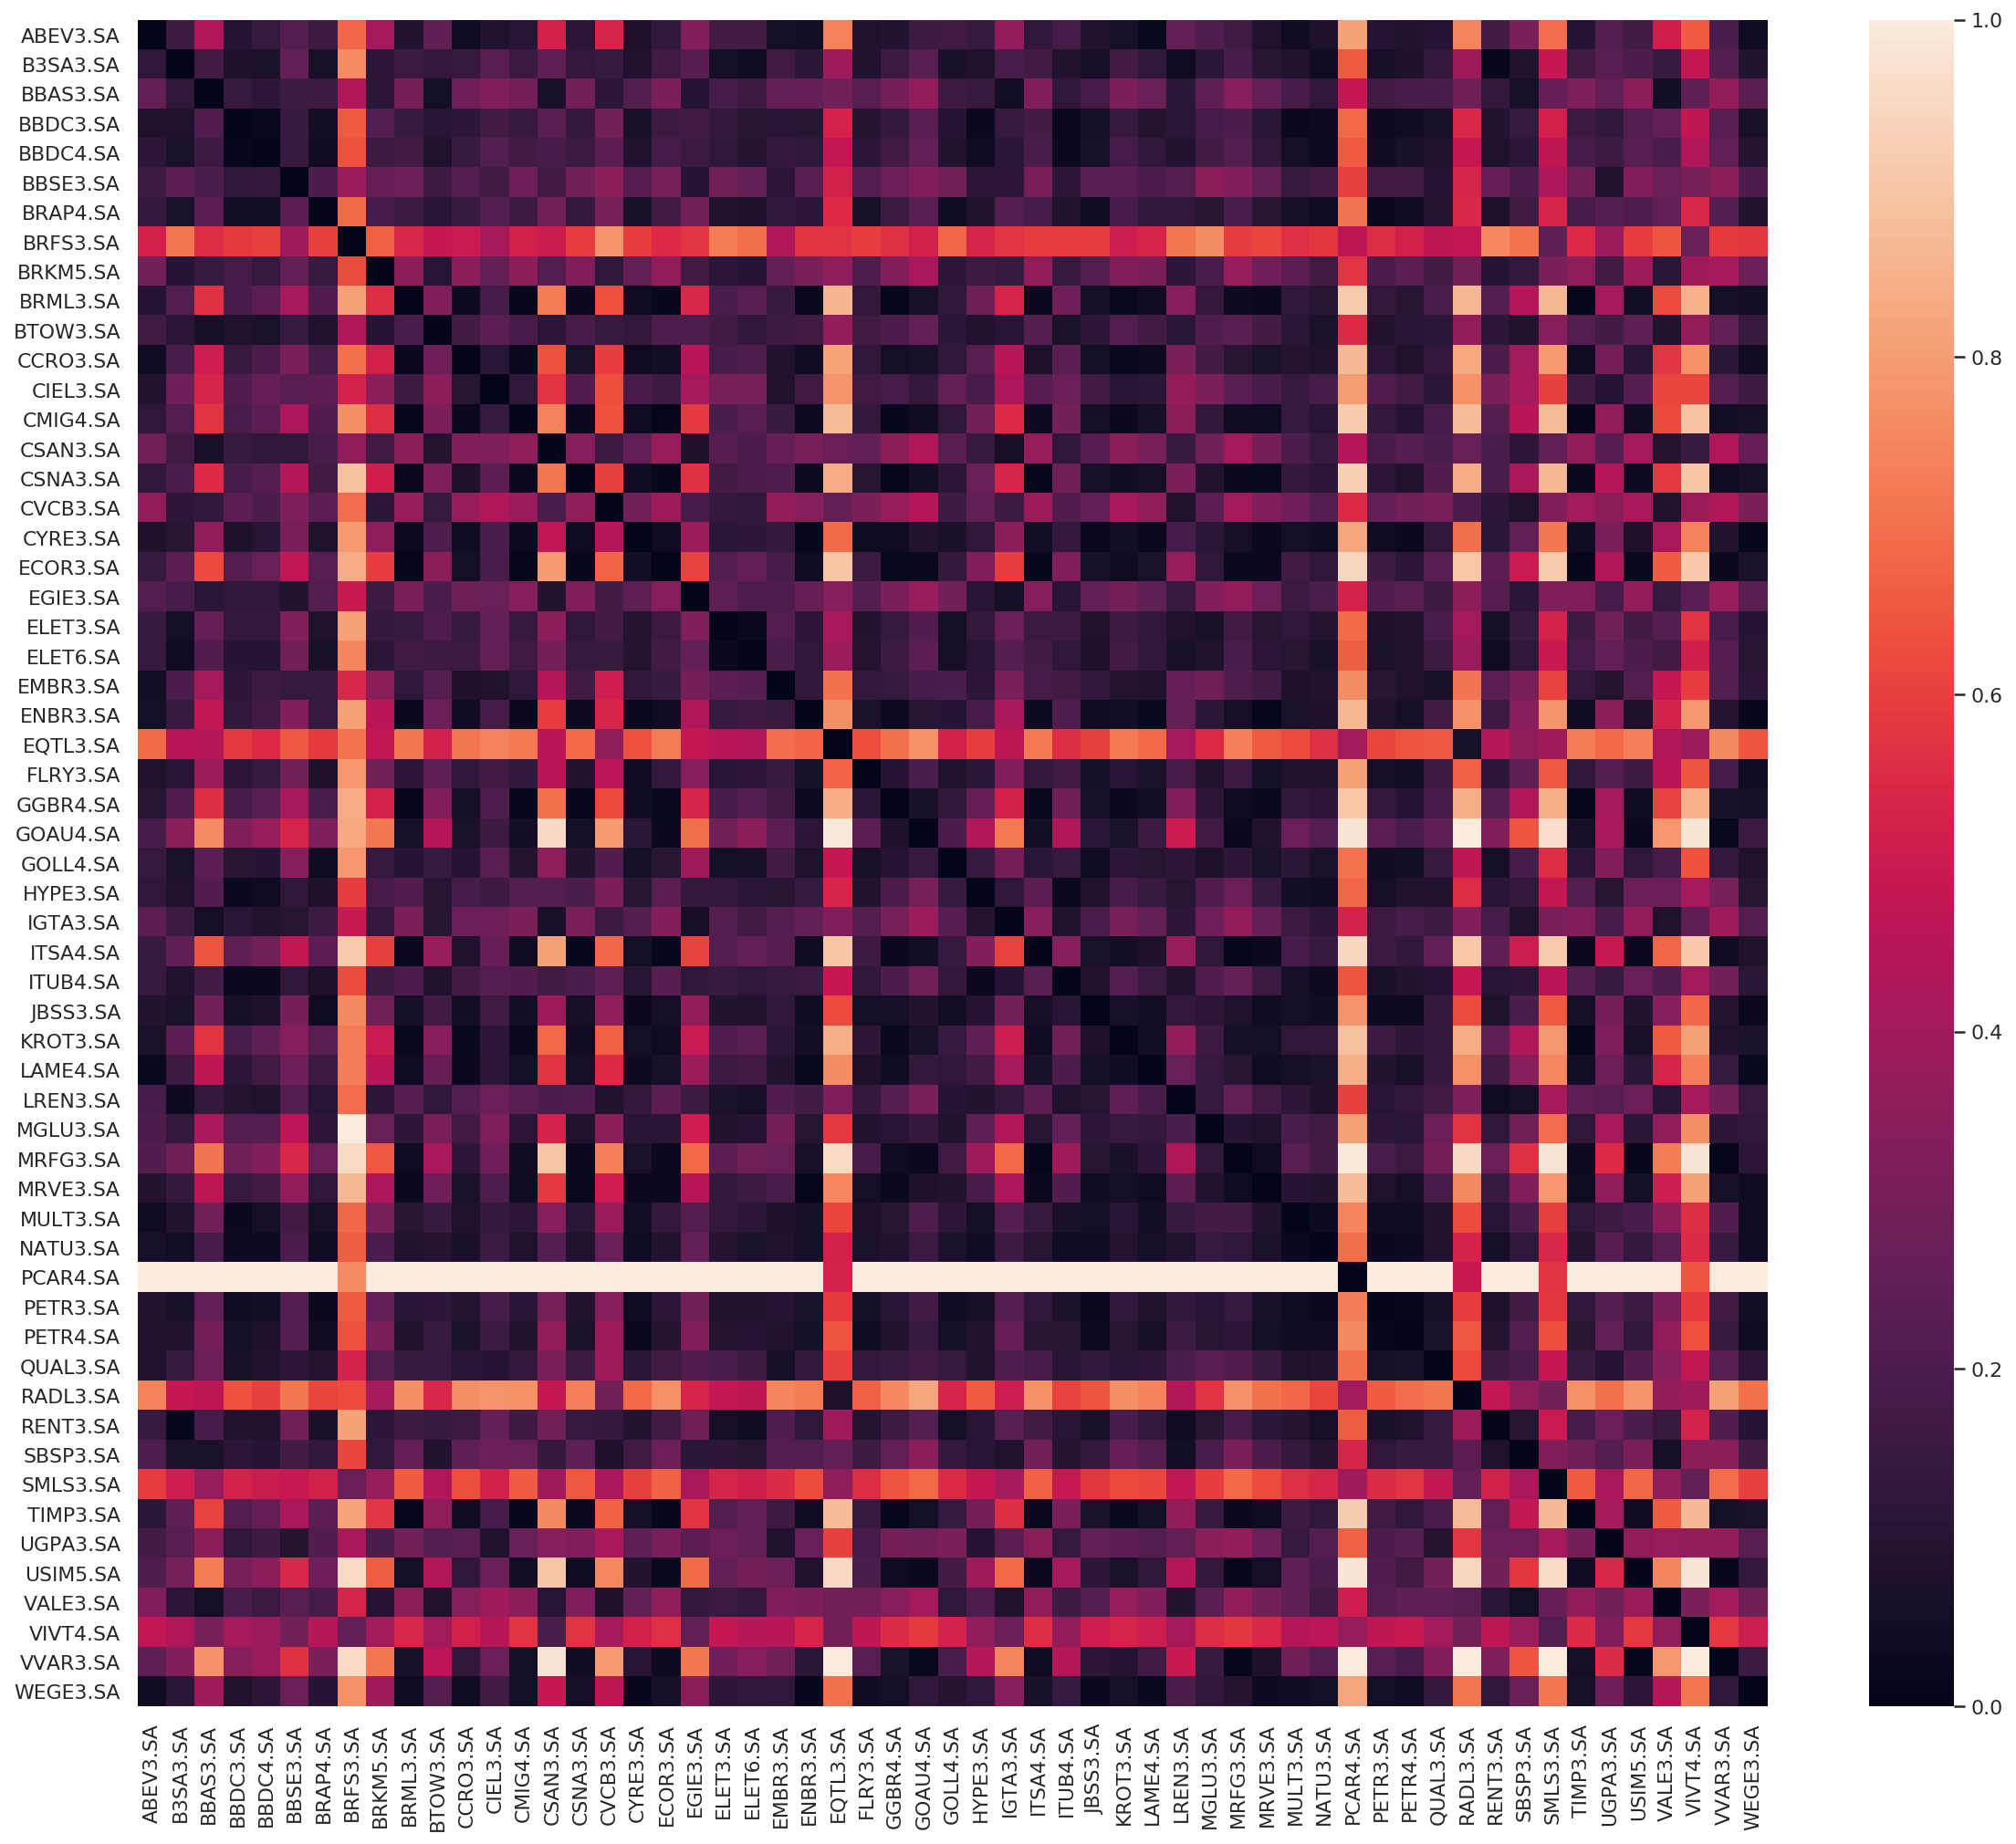

In [69]:
fig = plt.figure(figsize=[20, 17])
sns.heatmap((df_distances-df_distances.min())/(df_distances.max()-df_distances.min()))
fig.savefig("heatmap.png")

## Clustering com DBSCAN

In [48]:
h = DBSCAN(metric="precomputed", eps=135, min_samples=4)
p_dtw = h.fit(df_distances)

# Visualizacao por reducao de dimensionalidade

## Feature extraction

In [49]:
features = fresh.extract_features(df, column_sort="timestamp", column_id="ticker")

Feature Extraction: 100%|██████████| 10/10 [07:16<00:00, 43.60s/it]


## PCA

In [55]:
%matplotlib inline

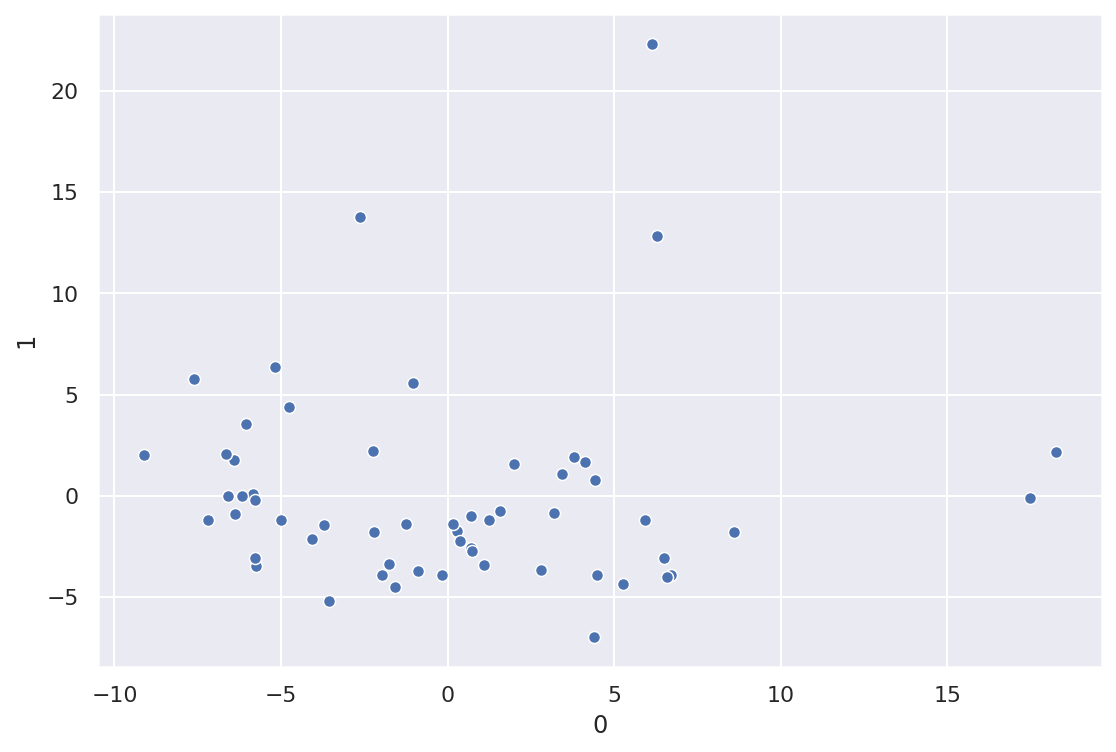

In [62]:
scaler = MinMaxScaler()
feats_transformed = pd.DataFrame(scaler.fit_transform(impute(features)))
pca = PCA(n_components=2)
feat_proj = pd.DataFrame(pca.fit_transform(feats_transformed))

plt.figure(figsize=[9,6])
sns.scatterplot(x=feat_proj[0],
                y=feat_proj[1],
                palette="rainbow")

## DBSCAN

In [57]:
h = DBSCAN(eps=4)
p_feat_proj = h.fit(feat_proj)

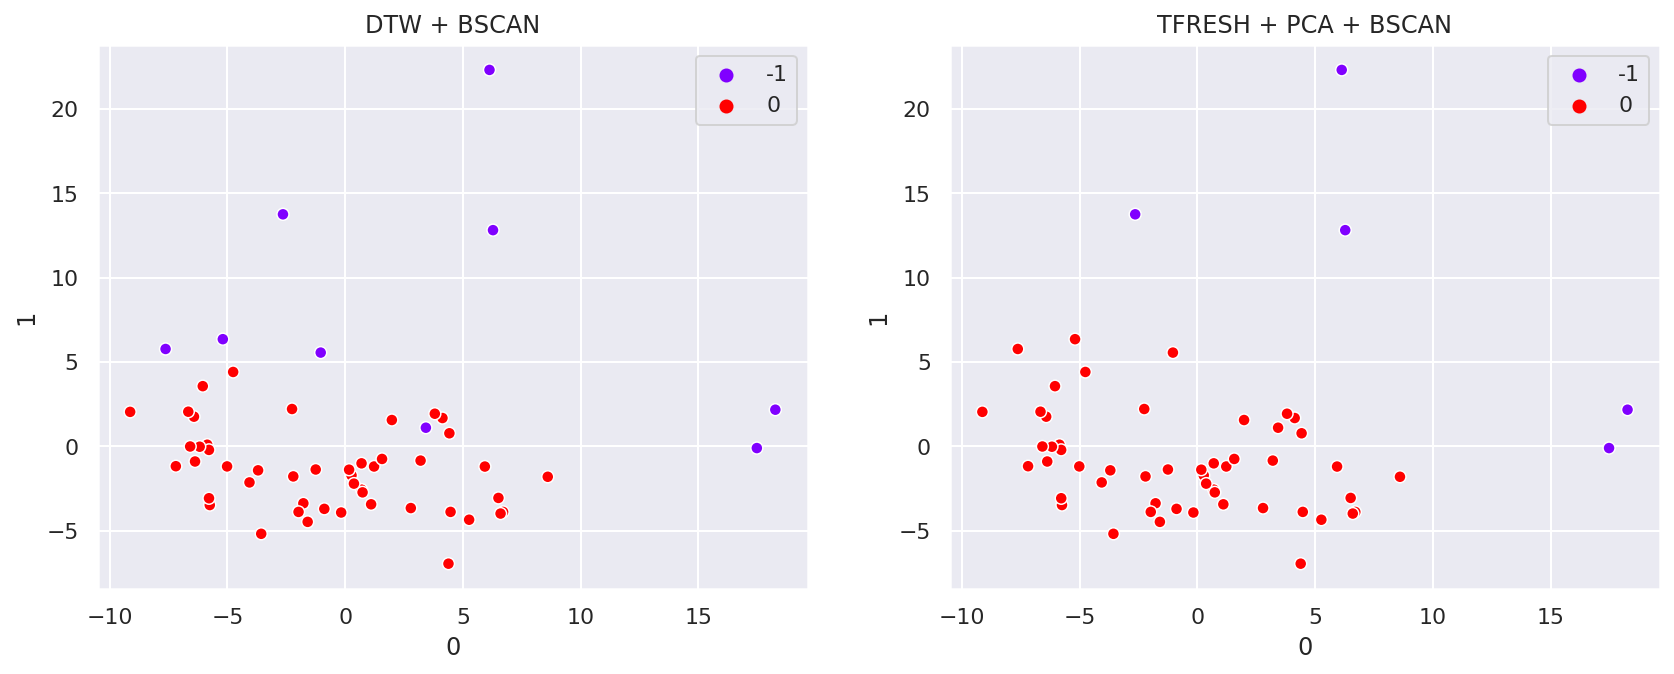

In [58]:
fig, ax = plt.subplots(1,2, figsize=[14,5])

ax[0].set_title("DTW + BSCAN")
ax[1].set_title("TFRESH + PCA + BSCAN")

sns.scatterplot(x=feat_proj[0],
                y=feat_proj[1],
                hue=p_dtw.labels_,
                ax=ax[0],
                palette="rainbow")
sns.scatterplot(x=feat_proj[0],
                y=feat_proj[1],
                hue=p_feat_proj.labels_,
                ax=ax[1],
                palette="rainbow")

## Series sem os outliers

In [235]:
bad_tickers = [a for (a,b) in (filter(lambda x: x[1] != 0, zip(unique_tickers, p_feat_proj.labels_)))]

df[~df["ticker"].isin(bad_tickers)].to_csv("filtered_tickers_2.csv")

In [207]:
bad_tickers

['BRFS3.SA', 'EQTL3.SA', 'PCAR4.SA', 'RADL3.SA', 'SMLS3.SA']

# TESTES ALEATORIOS

# Apple e AMD

In [ ]:
import seaborn as sns

ticker
AAPL    AxesSubplot(0.125,0.2;0.775x0.68)
AMD     AxesSubplot(0.125,0.2;0.775x0.68)
dtype: object

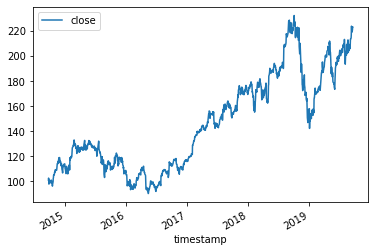

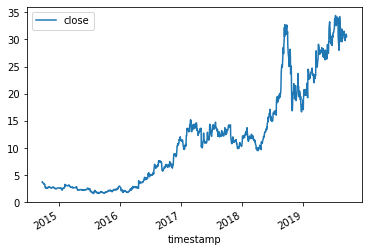

In [12]:
df[df["ticker"].isin(["AAPL", "AMD"])].groupby("ticker").plot(x="timestamp", y="close")

In [13]:
df[df["ticker"].isin(["AAPL", "AMD"])].to_csv("aapl_amd.csv")

In [98]:
df[df["ticker"] == "AAPL"].to_csv("aapl.csv")

# Todos 

In [12]:
df.to_csv("nasdaq_100.csv")

In [16]:
aapl_df = df[df["ticker"] == "AAPL"]

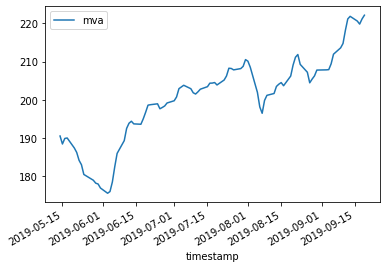

In [34]:
aapl_df.assign(mva=aapl_df["close"].rolling(3).mean()).tail(90).plot(x="timestamp", y="mva")

In [118]:
aapl_df.shape

(1258, 7)

In [54]:
p = Prophet(daily_seasonality=True)
p.fit(aapl_df.assign(ds=aapl_df["timestamp"], y=aapl_df["close"]))

In [59]:
forecast = p.predict(p.make_future_dataframe(periods=10)).tail()